In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest
import scipy.fftpack

# Just for in this notebook
import sys
sys.path.append('../assignment1/to_hand_in/')
import some_routines as sr
from tqdm import tqdm_notebook as tqdm

# 1. Normally distributed pseudo-random numbers

#### a) Write a RNG that returns a float $\in$ [0,1]. At minimum, use some combination of MWC and XOR-shift. Plot the numbers against each other. Also plot the value for the first 1000 numbers vs the index of the number. Finally have your code generate a million random numbers and plot the result of binning these in 20 bins 0.05 wide.

In [3]:
seed = 19231923
print (f"User seed is set to {seed}")

User seed is set to 19231923


In [4]:
class RandomGenerator(object):
    """
    Random generator should be an object because it maintains
    internal state between calls.
    """
    def __init__(self, seed):
        # make sure the everyhing is an unsigned 64 bit integer
        dtyp = np.uint64
        # the seed for the LGC
        self.X1 = dtyp(seed)
        # the seed for the XORshift
        self.X2 = dtyp(seed)
        # the seed for the MWC, has to be smaller than 2**32
        self.X3 = dtyp(seed)
        if self.X3 >= 2**32:
            raise ValueError("Please provide a seed smaller than 2**32")
        
        self.max_value = dtyp(2**64 - 1)
        
        # LCG values from Numerical Recipies
        self.a = dtyp(1664525)
        self.c = dtyp(1013904223)
        self.m = dtyp(2**32)
        
        # 64 bit XOR shift values from Numerical Recipes
        self.a1, self.a2, self.a3 = dtyp(21), dtyp(35), dtyp(4)
        
        # MWC values from Numerical Recipes
        self.a2 = dtyp(4294957665)
        self.maxx = dtyp(2**32-1)
        self.shift = dtyp(32)
        
    def lincongen(self, X):    
        return (self.a*X+self.c) % self.m

    def XORshift64(self, X):
        if X == 0:
            raise ValueError("Seed cannot be zero")
        X = X ^ (X >> self.a1)
        X = X ^ (X << self.a2)
        X = X ^ (X >> self.a3)
        
        return X
    
    def MWC(self, X):
        X = self.a2*(X & self.maxx) + (X >> self.shift)
        # Use as a random number only lowest 32 bits
        # But in a bitmix, we can use all 64 bits.
        return X
    
    def get_randomnumber(self):
        """
        Combine LCG and XORshift to produce random float 
        between 0 and 1
        """
        self.X1 = self.lincongen(self.X1)
        self.X2 = self.XORshift64(self.X2)
        self.X3 = self.MWC(self.X3)
        
        # output is XOR of these numbers
        
        return ((self.X1^self.X3)^self.X2)/self.max_value
    
        

In [5]:
RNGESUS = RandomGenerator(seed=seed)

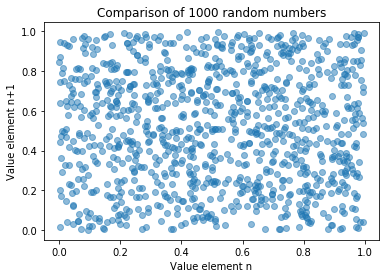

In [6]:
# Generate 1000 random numbers. Plot comparison
all_randnum = []
for i in range(1000):
    all_randnum.append(RNGESUS.get_randomnumber())

plt.plot(all_randnum,np.roll(all_randnum,1),'o',alpha=0.5)
plt.title(f'Comparison of {len(all_randnum)} random numbers')
plt.xlabel('Value element n')
plt.ylabel('Value element n+1')
plt.savefig('./plots/q1a1.png')
plt.show()
plt.close()

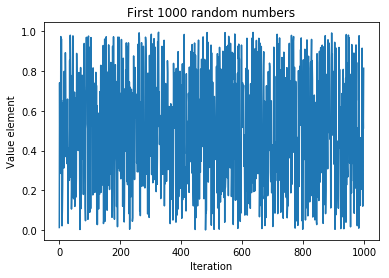

In [7]:
plt.plot(all_randnum)
plt.title(f'First {len(all_randnum)} random numbers')
plt.ylabel('Value element')
plt.xlabel('Iteration')
plt.savefig('./plots/q1a2.png')
plt.show()
plt.close()

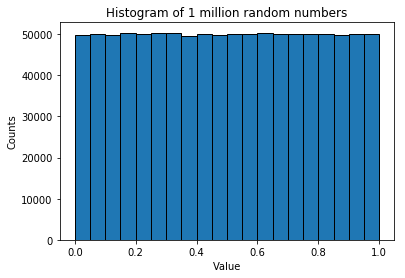

In [8]:
# Now generate 1 million random numbers. Plot histogram
all_randnum = []
for i in range(int(1e6)):
    all_randnum.append(RNGESUS.get_randomnumber())
all_randnum = np.array(all_randnum)
    
plt.hist(all_randnum,bins=sr.linspace(0,1,21),edgecolor='black')
plt.title(f'Histogram of 1 million random numbers')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.savefig('./plots/q1a3.png')
plt.show()
plt.close()

#### b. Now use the Box-Muller method to generate 1000 normally distributed random numbers.

In [9]:
def BoxMuller(randnums):
    """
    Given an input of random numbers drawn from Unif(0,1)
    return the same amount of random numbers drawn from Gaussian(0,1)
    """
    z1, z2 = randnums[:len(randnums)//2], randnums[len(randnums)//2:]
    a = np.sqrt(-2*np.log(z1))
    x1 = a*np.cos(2*np.pi*z2)
    x2 = a*np.sin(2*np.pi*z2)
    
    randnums2 = np.concatenate([x1,x2])
    
    return randnums2

def GaussianTransform(x,mu,sigma):
    """
    Takes x's drawn from a standard normal distribution and maps them 
    to arbitrary x ~ G(mu,sigma)
    """
    x *= sigma
    x += mu
    return x

def GaussianPdf(x,mean,sigma):
    """return the PDF of a Gaussian"""
    variance = sigma**2
    return 1/(np.sqrt(2*np.pi*variance)) * np.exp(-0.5*(x-mean)**2/variance)


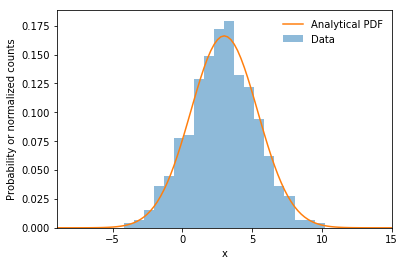

In [10]:
# We can use the first 1000 random numbers we have generated
randgauss = BoxMuller(all_randnum[:1000])
mu, sigma = 3, 2.4
randgauss = GaussianTransform(randgauss,mu,sigma)
# 20 equal width bins
hbins = sr.linspace(mu-3*sigma, mu+3*sigma,21)
nperbin, _, _ = plt.hist(randgauss,bins=hbins,label='data')
plt.close() # We could also set density is true, but since I am unsure
    # whether this is allowed, we shall normalize it manually.
bin_centers = (hbins[:-1] + hbins[1:])/2
binwidths = (hbins[1:] - hbins[:-1])
# Divide each bin by its width
# And divide by the total count to normalize
nperbin /= binwidths*np.sum(nperbin)

# Normalized histogram
plt.bar(bin_centers,nperbin,binwidths,label='Data',alpha=0.5)
# Analytical pdf
xs = sr.linspace(mu-5*sigma,mu+5*sigma,101)
plt.plot(xs, GaussianPdf(xs,mu,sigma),label='Analytical PDF',c='C1')

plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel('Probability or normalized counts')
plt.xlim(mu-5*sigma,mu+5*sigma)
plt.savefig('./plots/q1b1.png')
plt.show()
# plt.close()

#### c. Write a code that can do the KS-test on your function to determine whether it is consistent with a normal dist. For this, use $\mu=0$ and $\sigma=1$. Make a plot of the probability that your Gaussian random number generator is consistent with Gaussian distributed random numbers. Start with 10 random numbers and use in the plot a spacing of 0.1 dex until you have calculated it for $10^5$ random numbers on the x-axis. Compare your algorithm with the KS test from scipy by making another plot with the result from your KS-test and the KS-test from scipy.

The CDF of the standard normal distribution is given by
\begin{equation}
\Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-t^2/2} dt
\end{equation}

This can be written as 
\begin{equation}
\Phi(x) = \frac{1}{2} \left( 1+\mathrm{erf}\left(\frac{x}{\sqrt{2}} \right) \right)
\end{equation}

Where erf($x$) is called the error function. It is defined as 
\begin{equation}
\mathrm{erf}(x) = \frac{2}{\sqrt{\pi}} \int_{0}^x e^{-t^2} dt
\end{equation}

We calculate this error function by means of Romberg integration.

In [18]:
def romberg(func, lbound, ubound, order=6):
    """
    Calculate the integral of a function using Romberg's method
    with equal spaced abscissae
    
    func -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    order -- Amount of steps combining trapezoids, 
    		 final step will have 2**order intervals
    
    Returns 
    Value of the integral
    Error estimate
     
    The error estimate is given as the difference between last 2 orders
    """
    
    # for saving S_i,j's
    all_S = np.zeros((order,order))
    
    i = 0
    delta_x = (ubound-lbound)
    points = sr.linspace(lbound,ubound,2**i+1)
    integral = delta_x/2 * np.sum(func(points))
    all_S[0,0] = integral
    
    # Then calculate the first column (S_{i,0})
    for i in range(1,order):
        delta_x /= 2
        # add points in the middle
        points = sr.linspace(lbound,ubound,2**i+1)
        # add new points to the integral (use slicing to alternate)
        integral = 0.5*integral + delta_x * np.sum(func(points[1::2]))
        
        all_S[i,0] = integral
    
    for j in range(1,order): # column of Romberg table
        for i in range(j,order): # row of Romberg table
            all_S[i,j] = (4**j*all_S[i,j-1] - all_S[i-1,j-1]) / (
                           4**j - 1)
    
    return all_S[order-1,order-1], (all_S[order-1,order-1]-all_S[order-1,order-2])

def GaussianCdf(x):
    """
    Calculate the Gaussian CDF at point(s) x    
    """
    
    # the error function is the integral of this erfarg
    # from 0 to x/sqrt(2), multiplied by 2/sqrt(pi)
    erfarg = lambda t: np.exp(-t**2)
    
    if type(x) == np.ndarray or type(x) == list:
        if type(x) == list: 
            x = np.array(x)
        cdf = []
        for xnow in x:
            cdfn = 0.5*(1+2/np.sqrt(np.pi)*romberg(erfarg,0,xnow/np.sqrt(2)
                                              ,order=12)[0])
            cdf.append(cdfn)
        cdf = np.array(cdf)
            
    else:
        cdf = 0.5*(1+2/np.sqrt(np.pi)*romberg(erfarg,0,x/np.sqrt(2)
                                              ,order=12)[0])
    return cdf # returns a float or numpy array

In [33]:
def quicksort(arr):
    """
    Sort array with quicksort
    sorting is performed IN PLACE
    """
    N = len(arr)
    
    # Make sure first/last/middle elements are ordered correctly
    if arr[0] > arr[N-1]: # swap leftmost and rightmost elements
        arr[0], arr[N-1] = arr[N-1], arr[0]
    if arr[(N-1)//2] > arr[N-1]: # swap middle and rightmost element
        arr[(N-1)//2], arr[N-1] = arr[N-1], arr[(N-1)//2]
    if arr[0] > arr[(N-1)//2]: # swap middle and leftmost element
        arr[0], arr[(N-1)//2] = arr[(N-1)//2], arr[0]
    
    i, j = 0, N-1
    pivot = arr[(N-1)//2]
    pivot_position = (N-1)//2
    for _ in range(0,N//2): # Can improve this range()
        while arr[i] < pivot:
            i +=  1
        while arr[j] > pivot:
            j -= 1
        if j <= i:
            break # pointers have crossed
        else:
            if i == pivot_position: # have to keep track of where the pivot is
                pivot_position = j # going to switch them
            elif j == pivot_position:
                pivot_position = i
            # Both i and j found, swap them around the pivot and continue
            arr[i], arr[j] = arr[j], arr[i]
    
    if N > 2:
        # As long as we don't have 1 element arrays, perform quicksort on the subarrays
        leftarr = arr[:pivot_position] # left of the pivot
        rightarr = arr[pivot_position+1:] # right of the pivot        
        quicksort(leftarr)
        quicksort(rightarr)

def KScdf(z):
    """
    Return the CDF of the KS distribution at 'z'
    Used by the function KStest where 'z' is a function of 
    the KS test statistic 'D'
    """
    pi = np.pi
    exp = np.exp
    
    if z < 1.18:
        term = exp(-pi**2/(8*z**2))
        ans = np.sqrt(2*pi)/z 
        ans *= (term + term**9 + term**25)
        
    else:
        term = exp(-2*z**2)
        ans = 1-2*(term-term**4+term**9)
        
    return ans
        
def KStest(x, CDF):
    """
    Given an array of observations of x drawn from some PDF,
    this function uses the KS test to test whether x 
    follows the null hypothesis CDF
    
    x   -- array:    realisation from some PDF 
    CDF -- function: CDF of null hypothesis
    
    Returns
    D    -- float: KS test statistic
    pval -- float: p-value to reject null hypothesis 
        
    """
    # Sort x in ascending order to approximate the CDF
    quicksort(x)
    N = len(x)
    # empirical cdf
    indices = sr.linspace(1,N,N)
    ECDF = indices/N
    hCDF = CDF(x)
    distance = ECDF-hCDF
    # KS test statistic D
    D = sr.findmax(distance) 
    z = (np.sqrt(N)+0.12+0.11/np.sqrt(N))*D
    pval = 1-KScdf(z)
    
    return D, pval

def Kuiperpvalue(lamb,acc=1e-8,maxIT=200):
    """
    Returns the p value of the Kuiper test given the right lamb
    See the function KuiperTest for the definition of lamb 
    in terms of the Kuiper statistic V.
    """
    if lamb < 0.4:
        Q = 1.0
    else:
        diff = acc+1
        j = 0
        Q = 0
        while diff > acc:
            j += 1
            Qold = Q
            Q += (2*4*j**2*lamb**2-1)*np.exp(-2*j**2*lamb**2)
            diff = Q-Qold
            
            if j > maxIT:
                print (f"Not converged to the required accuracy of {acc}")
                break           
    return Q
    

def KuiperTest(x, CDF):
    """
    Given an array of observations of x drawn from some PDF,
    this function uses the KS test to test whether x 
    follows the null hypothesis CDF
    
    x   -- array:    realisation from some PDF 
    CDF -- function: CDF of null hypothesis
    
    Returns
    V    -- float: Kuiper test statistic
    pval -- float: p-value to reject null hypothesis 
        
    """
    # Sort x in ascending order to approximate the CDF
    quicksort(x)
    N = len(x)
    # empirical cdf
    indices = sr.linspace(1,N,N)
    ECDF = indices/N
    hCDF = CDF(x)
    # Maximum distance above
    distance = ECDF-hCDF
    Dplus = sr.findmax(distance) 
    # Maximum distance below
    distance = hCDF-ECDF
    Dminus = sr.findmax(distance)
    V = Dplus + Dminus
    
    lamb = (np.sqrt(N)+0.155+0.24/np.sqrt(N))*V
    pval = Kuiperpvalue(lamb)
    
    return D, pval
    
    

In [36]:
# 10**5 random numbers drawn from standard normal dist
randgauss = BoxMuller(all_randnum[:100000])

A spacing of 0.1 dex means we increase by a factor $10^{0.1}$. So, to get up to $10^5$ starting from $10^1$, we have to increase by this factor 40 times

In [42]:
# my values
all_D = []
all_p = []
# scipy values
all_D_sp = []
all_p_sp = []

all_numpoints = []

# A spacing of 0.1 dex means we increase by a factor $10^{0.1}$.
# So, to get up to $10^5$ starting from $10^1$, we have to increase 
# by this factor 40 times
for i in tqdm(range(41)):
    numpoints = int(10*10**(0.1*i))
    all_numpoints.append(numpoints)
    D, pval = KStest(randgauss[:numpoints],GaussianCdf)
    all_D.append(D)
    all_p.append(pval)
    D, pval = kstest(randgauss[:numpoints],GaussianCdf)
    all_D_sp.append(D)
    all_p_sp.append(pval)

10.0
12.589254117941673
15.848931924611136
19.952623149688797
25.118864315095802
31.622776601683796
39.810717055349734
50.11872336272724
63.095734448019336
79.43282347242815
100.0
125.89254117941675
158.48931924611142
199.526231496888
251.1886431509581
316.2277660168379
398.1071705534973
501.1872336272725
630.9573444801933
794.3282347242816
1000.0
1258.9254117941675
1584.8931924611143
1995.2623149688807
2511.8864315095825
3162.2776601683795
3981.0717055349733
5011.872336272725
6309.573444801937
7943.282347242822
10000.0
12589.254117941675
15848.93192461114
19952.62314968881
25118.86431509582
31622.776601683796
39810.717055349734
50118.72336272725
63095.734448019364
79432.82347242822
100000.0



In [37]:
print (D, pval)
print ("THE P-VALUE IS WRONG FOR SOME REASON")

0.031849189985491244 0.25829848510944586
THE P-VALUE IS WRONG FOR SOME REASON


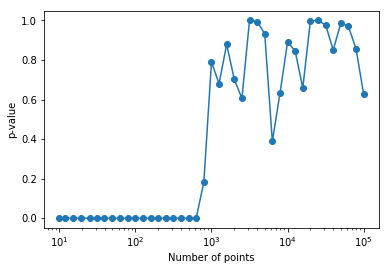

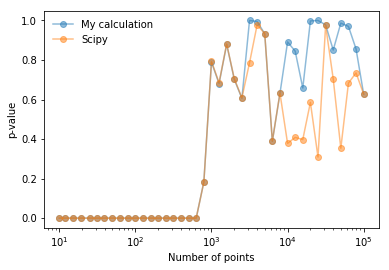

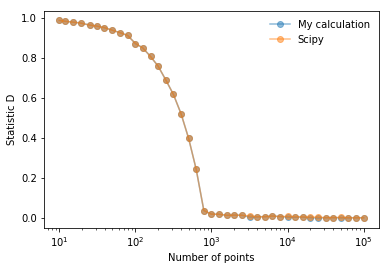

In [52]:
plt.plot(all_numpoints,all_p,'-o')
plt.xlabel('Number of points')
plt.ylabel('p-value')
plt.xscale('log')
# plt.yscale('log')
plt.show()


plt.plot(all_numpoints,all_p,'-o',label='My calculation',alpha=0.5)
plt.plot(all_numpoints,all_p_sp,'-o',label='Scipy',alpha=0.5)
plt.xlabel('Number of points')
plt.ylabel('p-value')
plt.xscale('log')
# plt.yscale('log')
plt.legend(frameon=False)
plt.show()


plt.plot(all_numpoints,all_D,'-o',label='My calculation',alpha=0.5)
plt.plot(all_numpoints,all_D_sp,'-o',label='Scipy',alpha=0.5)
plt.xlabel('Number of points')
plt.ylabel('Statistic D')
plt.xscale('log')
# plt.yscale('log')
plt.legend(frameon=False)
plt.show()

In [66]:
np.allclose(all_D,all_D_sp,1e-10)
tst = np.array(all_D)
tst2 = np.array(all_D_sp)
indxs = tst == tst2
print (np.where(tst != tst2))

for i in range(np.sum(np.invert(indxs))):
    print (tst[np.invert(indxs)][i]-tst2[np.invert(indxs)][i])

print ("...")
# print (tst,tst2)
for i in range(np.sum((indxs))):
    print (tst[(indxs)][i]-tst2[(indxs)][i])


(array([25, 26, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),)
-0.005701432396548856
-0.0008836609511071458
-0.003327147074939446
-0.002452750072545279
-0.001316783354836315
-0.0026755677062183514
-0.005261775981001415
-3.776860702703333e-05
-0.00047273710235609667
-0.0021295444423789778
-0.000903725663539745
-0.00028252467121214764
...
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# 2. Making an initial density field

#### Generate a Fourier plane. This can be done by generating a 2D matrix with complex entries, of which the real and imaginary parts may just be normal random numbers with mean zero and variance given by the power spectrum. Assume $$P(k) \propto k^n.$$ 

#### The matrix that is constructed is required to have certain symmetries such that after the IFFT, the matrix is real. This mean that we have the symmetry $\tilde{Y}(-k) = \tilde{Y}*(k).$ Using this information you can make a Gaussian random field. Make plots of three Gaussian random fields, using n=-1, n=-2 and n=-3. Give the plots a size of 1024x2014 pixels. The axis should be in physical size (e.g., Mpc). Choose a minimum physical size and explain how this impacts the maximum physical size, the minimum $k$ and maximum $k$

The (1D) inverse discrete Fourier transform can be written as
\begin{equation}
f(n) = \sum_{j=0}^{N-1} \hat(f) e^{i \frac{2\pi}{N} jn}
\end{equation}
where $n$ runs from $0$ to $N-1$ and we have not defined a normalization. In this case, $n$ can be thought of as the indices of the function $f$, which is sampled at $f(0),..,f(N-1)$

The mapping from integer $j$ to wave number $k$ is as follows
\begin{equation}
k = \frac{2\pi}{N} j
\end{equation}
For $-N/2 \leq j \leq N/2$.

Working with indices, it is most convenient to let $j$ run from $0$ to $N-1$, this corresponds to 
$$k=0,\frac{2\pi}{N},\frac{4\pi}{N},...,\frac{2\pi}{N}\times \frac{N}{2}, \frac{2\pi}{N}\left(-\frac{N}{2}+1\right),...,\frac{2\pi}{N}(-1) $$

Since we only have to generate the upper half of the Fourier plane, and $N=1024$ is an even number we can let our two indices run from $N/2=512$ to generate the upper half of the Fourier plane. Additionally, since the y-axis in the Fourier plane also consists of complex conjugates symmetric in $x$, one of the indices 

In [89]:
# We only have to generate the upper half of the fourier plane
# since the lower half will be given by the complex conjugate 
# because the field has to be real. Similary, for ky=0
# we have that opposite kx's will be complex conjugates.


def model_n(k, n):
    return k**n

def density_field(N, model, randgauss):
    """
    Generate a real density field with mean 0
    that follows a given power spectrum model.
    
    N         -- int: size of the field
    model     -- Power spectrum model function of k
    randgauss -- N**2 standard normal numbers for quick construction
    """
    
    fftfield = np.zeros((N,N),dtype='complex')
    # One step in k
    dk = 2*np.pi/N 
    # The fourier frequencies are different for (un)even N
    Neven = N%2 # add one to loops if N is uneven
    
    counter = 0
    # Loop over all kx modes
    for i in range(0,N): 
        if i <= N//2:
            kx = dk*i
        else:
            kx = (-N+i)*dk
            
        # start at j=1 because we generate the kx's on the 
        # ky-axis seperately. Additionally, only generate the 
        # upper half of the fourier plane (ky>0)
        for j in range(1,N//2+Neven):
            ky = dk*j               
            k = (kx**2+ky**2)**0.5
            # Transform standard normal numbers to correct variance
#             fftfield[i,j] = np.random.normal()*model(k)**0.5 + 1j*(
#                             np.random.normal()*model(k)**0.5)
            fftfield[i,j] = np.random.normal(0,model(k)**0.5) + 1j*(
                            np.random.normal(0,model(k)**0.5))
#             counter += 2
    if Neven == 0:
        # Then we have an even amount of N, so do not forget the N//2
        # column
        ky = N//2*dk
        for i in range(1,N//2):
            kx = dk*i
            k = (kx**2+ky**2)**0.5
            fftfield[i,N//2] = np.random.normal(0,model(k)**0.5) +1j*(
                               np.random.normal(0,model(k)**0.5))
            # Complex conjugate
            fftfield[-i,N//2] = fftfield[i,N//2].real - 1j*(
                                fftfield[i,N//2].imag)
            
        # Some numbers have no counterpart, they are their own 
        # complex conjugate. i.e., they are real.
        k = (N//2*dk)
        fftfield[0,N//2] = np.random.normal(0,model(k)**0.5) + 1j*0
        fftfield[N//2,0] = np.random.normal(0,model(k)**0.5) + 1j*0
        k *= np.sqrt(2)
        fftfield[N//2,N//2] = np.random.normal(0,model(k)**0.5) + 1j*0
        
    # The kx-axis is conjugate symmetric in x
    # so we only have to generate half
    for i in range(1,N//2+Neven):
        fftfield[i,0] = np.random.normal(0,model(k)**0.5) + 1j*(
                            np.random.normal(0,model(k)**0.5))
        # complex conjugate
        fftfield[-i,0] = fftfield[i,0].real - 1j*fftfield[i,0].imag
        
        
    # Finally generate all modes below the ky=0 axis by conjugating
    # all modes above the ky=0 axis 
    for i in range(0,N):
        for j in range(N//2,N):
            fftfield[i,j] = fftfield[-i,-j].real - 1j*fftfield[-i,-j].imag
    
    # Don't forget that the [0,0] component of the field has to be 0
    # for a GRF with mean 0
    fftfield[0,0] = 0 + 1j*0
    
    # Multiply by N to undo the normalization build into scipy
    densfield = scipy.fftpack.ifft2(fftfield)*N
    
    return fftfield, densfield
            
            

In [67]:
# use the one million random numbers we generated before
randgauss = BoxMuller(all_randnum)
# generate a few more numbers so we can fill the fourier plane
amount = 1024**2-len(randgauss)
new_randnum = []
for i in range(amount):
    new_randnum.append(RNGESUS.get_randomnumber())
new_randnum = np.array(new_randnum)
randgauss = np.concatenate([randgauss,BoxMuller(new_randnum)])

In [102]:
model = lambda k: model_n(k,1)
fftfield, densfield = density_field(1024,model,None)

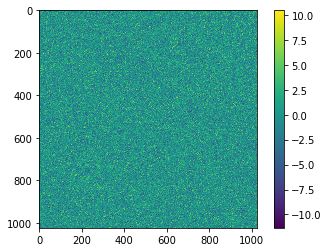

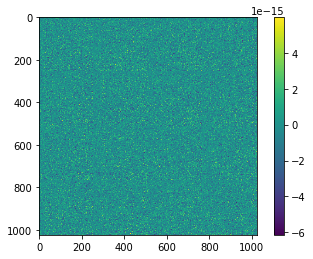

In [103]:
plt.imshow(densfield.real)
plt.colorbar()
plt.show()

plt.imshow(densfield.imag)
plt.colorbar()
plt.show()